In [67]:
# %load_ext autoreload
# %autoreload 2
import itertools as itt
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import glob
import multiprocessing as mp
import argparse
import re
import shutil
import mat73
%matplotlib inline

from minian.utilities import open_minian

In [68]:
import matplotlib as mpl
plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.color'] = 'k'
plt.rcParams['svg.fonttype'] = 'none'


In [69]:
def hex_to_rgb(hex):
  return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))


In [70]:
# minian_cross = '/scratch/09117/xz6783/Xu/PL_miniscope/PL/Analysis/Cross_regist/Satiation_vs_conflict/minian_cross'

In [71]:
cell_reg = '/scratch/09117/xz6783/minian/cross_regist/mat_files/'
cell_reg_output = '/scratch/09117/xz6783/Xu/PL_miniscope/PL/Analysis/Cross_regist/Satiation_vs_conflict/cell_reg/'

In [72]:
animal_id = '2I5'
session_conflict = 'conflict'
pattern_conflict  = os.path.join(cell_reg, animal_id, '**', f'{session_conflict }*.mat')
matching_files_conflict  = glob.glob(pattern_conflict )

# Load the DataFrame from the first matching file
mat_file_path_conflict  = matching_files_conflict [0]
footprints_conflict  = mat73.loadmat(mat_file_path_conflict)['footprints']


In [73]:
binarized_max_footprints_conflict  = (footprints_conflict.max(axis = 0)>0.004).astype('int')

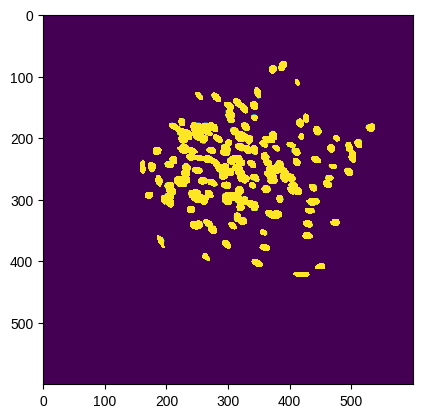

In [74]:
plt.imshow(binarized_max_footprints_conflict , cmap = 'viridis', vmin = 0,vmax = 0.01)

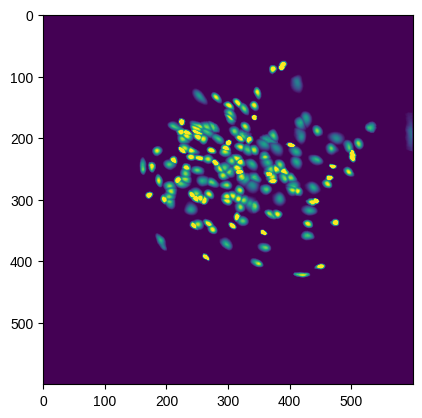

In [75]:
plt.imshow(footprints_conflict.max(axis = 0), cmap = 'viridis', vmin = 0,vmax = 0.01)

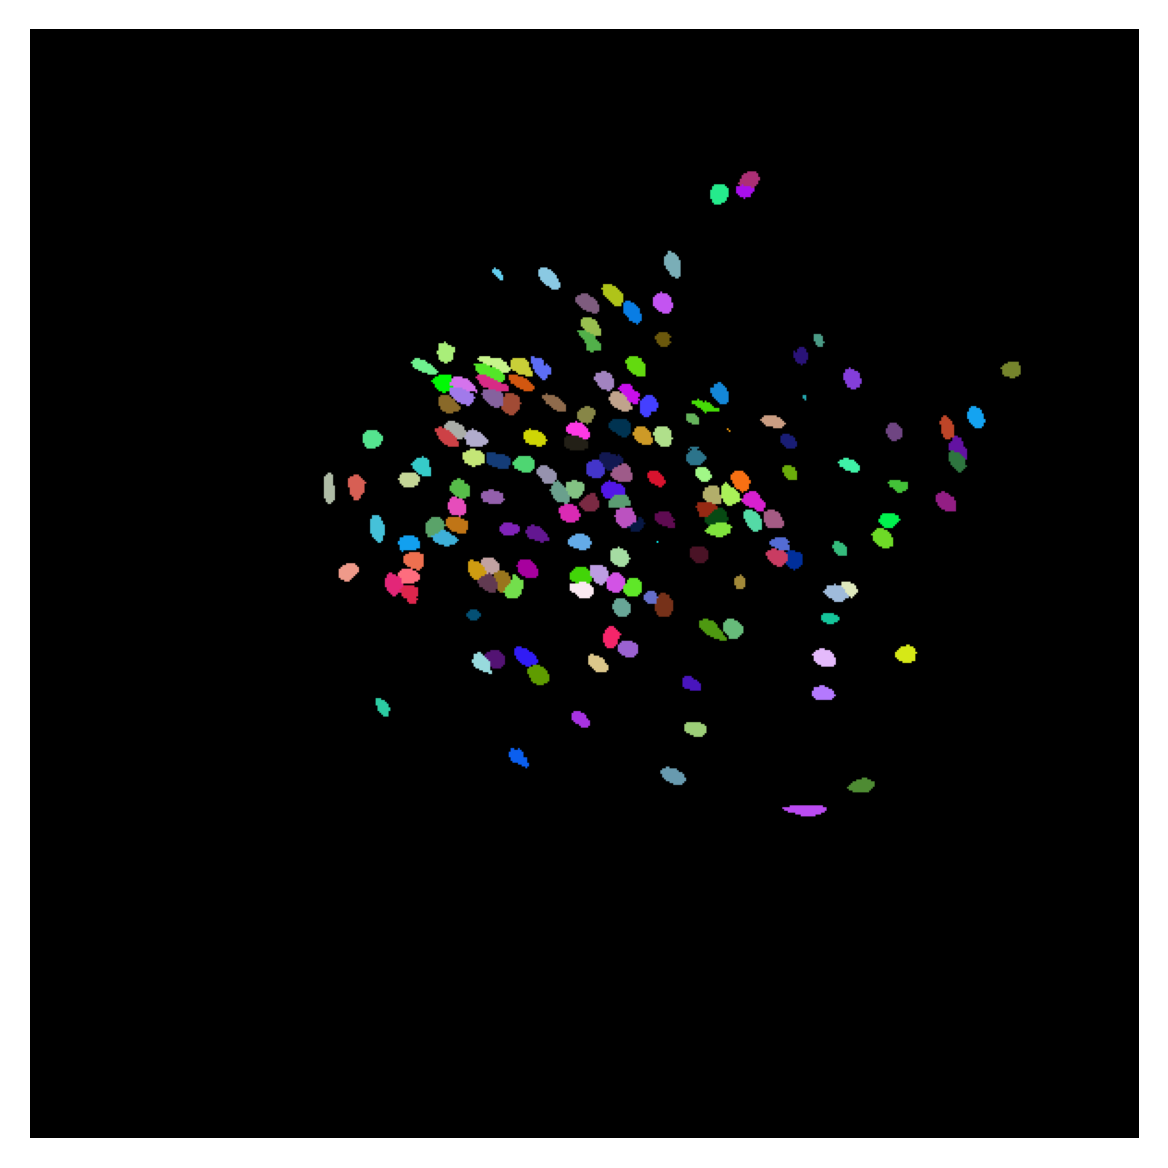

In [76]:
# Create a color image with the shape (600, 600, 3)
color_image = np.zeros((footprints_conflict.shape[1], footprints_conflict.shape[2], 3), dtype=np.uint8)


fig = plt.figure(dpi = 300) 
for i in range(footprints_conflict.shape[0]):
    np.random.seed(i)
    mask = footprints_conflict[i] > 0.005  # Find where the footprint is present
    color_image[mask] = np.random.randint(0, 256, 3)  # Assign the color to these positions

# Display the pseudo-colored image
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig3/fig3_fov.svg")
plt.show()

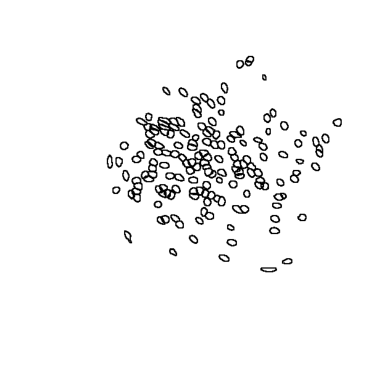

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel


color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 3), dtype=np.uint8) * 255

for i in range(footprints_conflict.shape[0]):
    np.random.seed(i)  # Seed for reproducibility
    
    # Extract the current footprint and find edges
    footprint = (footprints_conflict[i]>0.004).astype('int')
    edge_x = sobel(footprint, axis=0, mode='constant')
    edge_y = sobel(footprint, axis=1, mode='constant')
    edge_magnitude = np.hypot(edge_x, edge_y)
    
    # Create an edge mask
    edge_mask = edge_magnitude > edge_magnitude.mean() * 1.5  # Threshold can be adjusted
    
    # Generate a random color for the edges of this footprint
    color = [0,0,0]
    
    # Color the edges on the color image
    color_image[edge_mask] = color

# Display the pseudo-colored image
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()


In [78]:
conflict_path = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Conflict/"
satiation_path = "/scratch/09117/xz6783/minian/Satiation/Session Combined"
id_path = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Conflict/"
files = os.listdir(id_path)


In [79]:
dpath_conflict = os.path.join(conflict_path, animal_id)
pattern_conflict = os.path.join(dpath_conflict, "**", "minian")
minian_ds_path_conflict = glob.glob(pattern_conflict, recursive=True)[0]
if not os.path.exists(minian_ds_path_conflict):
    print(f"Minian dataset path {minian_ds_path_conflict} not found for animal ID {animal_id}")

minian_ds_conflict = open_minian(minian_ds_path_conflict)

# Assuming labels and unitid are as you defined
labels_conflict = minian_ds_conflict['C'].unit_labels.values
unitid_conflict = minian_ds_conflict['C'].unit_id.values

# Create the mapping directly from unit_id to label
unit_id_to_label_conflict = {u_id: label for label, u_id in zip(labels_conflict, unitid_conflict)}
mat_to_unitid_conflict = {label: u_id for label, u_id in zip(np.arange(1, len(unitid_conflict)+1), unitid_conflict)}

# Get minian_ds for satiation
dpath_satiation = os.path.join(satiation_path, animal_id)
pattern_satiation = os.path.join(dpath_satiation, "**", "minian")
minian_ds_path_satiation = glob.glob(pattern_satiation, recursive=True)[0]
if not os.path.exists(minian_ds_path_satiation):
    print(f"Minian dataset path {minian_ds_path_satiation} not found for animal ID {animal_id}")
minian_ds_satiation = open_minian(minian_ds_path_satiation)

# Assuming labels and unitid are as you defined
labels_satiation = minian_ds_satiation['C'].unit_labels.values
unitid_satiation = minian_ds_satiation['C'].unit_id.values

# Create the mapping directly from unit_id to label
unit_id_to_label_satiation = {u_id: label for label, u_id in zip(labels_satiation, unitid_satiation)}
mat_to_unitid_satiation = {label: u_id for label, u_id in zip(np.arange(1, len(unitid_satiation)+1), unitid_satiation)}

# Get mapping pickle file
pattern = os.path.join(cell_reg_output, f"{animal_id}*.mat")
matching_files = glob.glob(pattern)

# Load the DataFrame from the first matching file
mat_file_path = matching_files[0]
cell_to_index_map = mat73.loadmat(os.path.join(cell_reg_output, mat_file_path))['cell_registered_struct']['cell_to_index_map'].astype('int64')

# Matlab indexes starting from 1. Correct this for Python.
# Then NaN out the unmatched cells.
match_map = pd.DataFrame(cell_to_index_map)
match_map.columns = ['Conflict_cell_id', 'Satiation_cell_id']

# # Update DataFrame with mapped labels
match_map['Conflict_cell_id'] = match_map['Conflict_cell_id'].map(mat_to_unitid_conflict)
match_map['Satiation_cell_id'] = match_map['Satiation_cell_id'].map(mat_to_unitid_satiation)
match_map['Conflict_cell_id'] = match_map['Conflict_cell_id'].map(unit_id_to_label_conflict)
match_map['Satiation_cell_id'] = match_map['Satiation_cell_id'].map(unit_id_to_label_satiation)

# # Drop duplicate rows where 'Conflict' and 'Satiation' are the same
match_map = match_map.dropna().drop_duplicates(subset=['Conflict_cell_id', 'Satiation_cell_id'])

In [80]:
cell_to_index_map_corrected = cell_to_index_map -1

In [81]:
cell_to_index_map_corrected

array([[  0,  -1],
       [  1,  -1],
       [  2,  -1],
       [  3,   3],
       [  4,  -1],
       [  5,  -1],
       [  6,  10],
       [  7,  -1],
       [  8,  -1],
       [  9,  14],
       [ 10,  20],
       [ 11,  -1],
       [ 12,  27],
       [ 13,  30],
       [ 14,  -1],
       [ 15,  -1],
       [ 16,  -1],
       [ 17,  -1],
       [ 18,  -1],
       [ 19,  -1],
       [ -1,  37],
       [ 21,  -1],
       [ 22,  -1],
       [ 23,  -1],
       [ 24,  -1],
       [ 25,  -1],
       [ 26,  -1],
       [ 27,  48],
       [ 28,  -1],
       [ 29,  -1],
       [ 30,  63],
       [ 31,  -1],
       [ 32,  -1],
       [ 33,  38],
       [ 34,  -1],
       [ 35,  -1],
       [ 36,  58],
       [ 37,  68],
       [ 38,  -1],
       [ 39,  -1],
       [ 40,  -1],
       [ 41,  -1],
       [ 42,  -1],
       [ 43,  -1],
       [ 44,  -1],
       [ 45,  -1],
       [ 46,  -1],
       [ 47,  -1],
       [ 48,  -1],
       [ 49,  72],
       [ 50,  -1],
       [ 51,  -1],
       [ 52,

In [82]:
cell_to_index_map_corrected[cell_to_index_map_corrected[:,1].argsort()]

array([[  0,  -1],
       [101,  -1],
       [102,  -1],
       [105,  -1],
       [106,  -1],
       [107,  -1],
       [108,  -1],
       [109,  -1],
       [111,  -1],
       [112,  -1],
       [113,  -1],
       [114,  -1],
       [115,  -1],
       [116,  -1],
       [117,  -1],
       [119,  -1],
       [ 99,  -1],
       [120,  -1],
       [ 97,  -1],
       [ 95,  -1],
       [ 77,  -1],
       [ 78,  -1],
       [ 79,  -1],
       [ 80,  -1],
       [ 81,  -1],
       [ 83,  -1],
       [ 84,  -1],
       [ 85,  -1],
       [ 87,  -1],
       [ 88,  -1],
       [ 89,  -1],
       [ 90,  -1],
       [ 91,  -1],
       [ 93,  -1],
       [ 94,  -1],
       [ 96,  -1],
       [ 76,  -1],
       [122,  -1],
       [124,  -1],
       [100,  -1],
       [149,  -1],
       [150,  -1],
       [151,  -1],
       [153,  -1],
       [154,  -1],
       [155,  -1],
       [156,  -1],
       [157,  -1],
       [158,  -1],
       [159,  -1],
       [160,  -1],
       [161,  -1],
       [162,

In [83]:
animal_id = '2I5'
session_satiation = 'satiation'
pattern_satiation  = os.path.join(cell_reg, animal_id, '**', f'{session_satiation }*.mat')
matching_files_satiation  = glob.glob(pattern_satiation )

# Load the DataFrame from the first matching file
mat_file_path_satiation  = matching_files_satiation [0]
footprints_satiation  = mat73.loadmat(mat_file_path_satiation)['footprints']

In [84]:
cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,0] == 0)[0], 1]

array([-1])

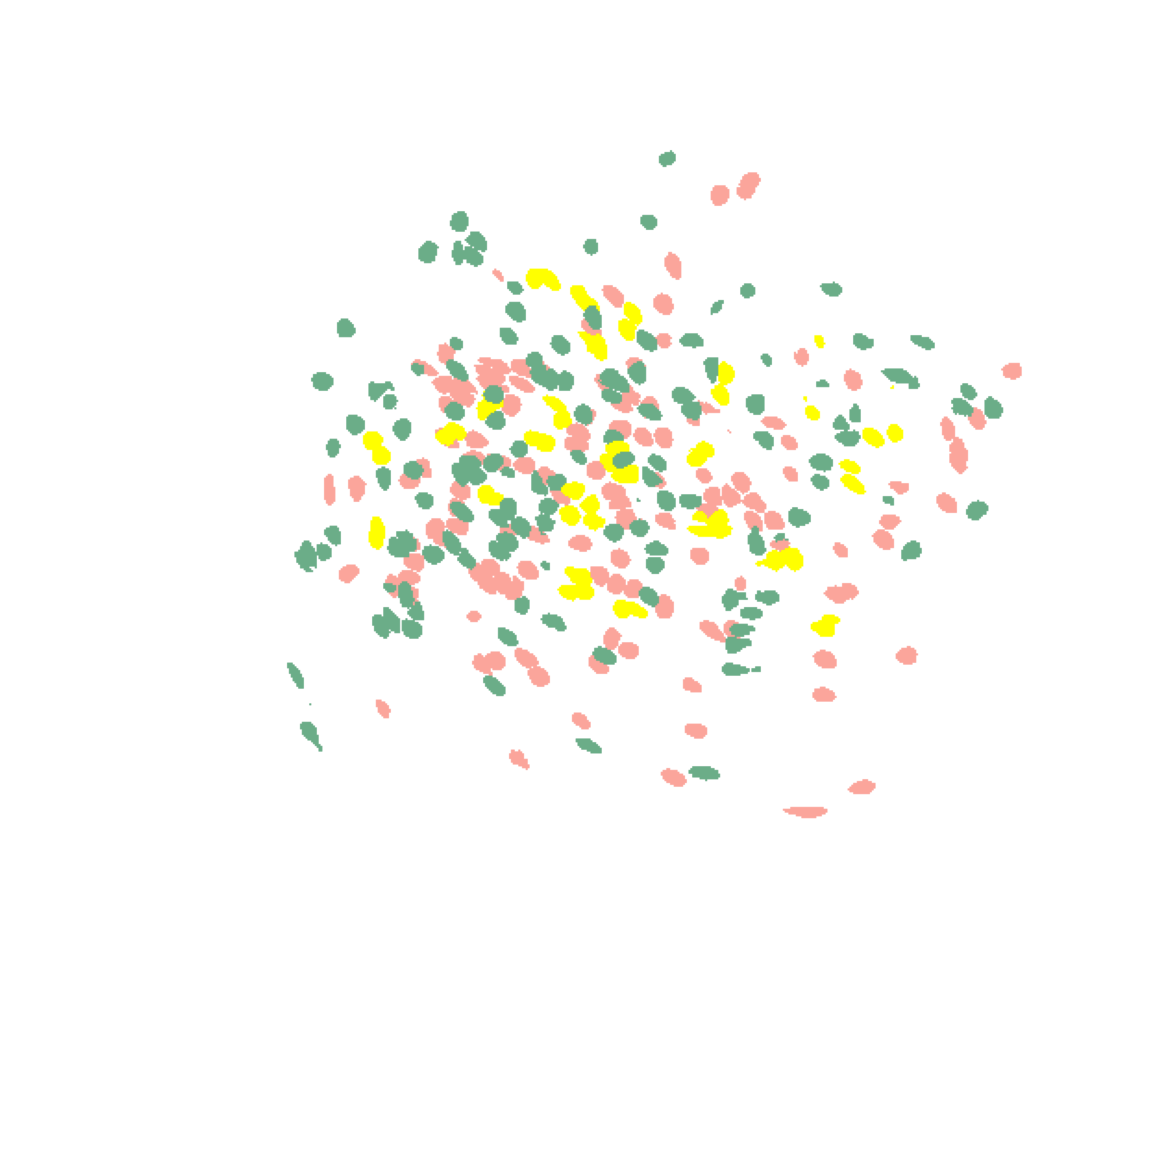

In [85]:

color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 4), dtype=np.uint8) * 255


for i in range(footprints_conflict.shape[0]):
    mask = footprints_conflict[i] > 0.005  # Find where the footprint is present
    if cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,0] == i)[0], 1] == -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('salmon')) * 255, [180]]))  # Assign the color to these positions
    elif cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,0] == i)[0], 1] != -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('yellow')) * 255, [255]]))
        
for i in range(footprints_satiation.shape[0]):
    mask = footprints_satiation[i] > 0.005  # Find where the footprint is present
    if cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,1] == i)[0], 0] == -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('seagreen')) * 255, [180]]))  # Assign the color to these positions
    elif cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,1] == i)[0], 0] != -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('yellow')) * 255, [255]]))

        # Display the pseudo-colored image
plt.figure(figsize = (4,4),dpi =300)
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.tight_layout()
plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig4/fig4_crossmap.svg", transparent=True)


plt.show()

In [86]:
output_dir = '/scratch/09117/xz6783/Xu/PL_miniscope/PL/Analysis/Satiation/analysis_output'

excited_hungry = pd.read_csv(os.path.join(output_dir, 'Excited_Hungry.csv'), index_col= 0)
inhibited_hungry = pd.read_csv(os.path.join(output_dir, 'Inhibited_Hungry.csv'), index_col= 0)
excited_satiated = pd.read_csv(os.path.join(output_dir, 'Excited_Satiated.csv'), index_col= 0)
inhibited_satiated = pd.read_csv(os.path.join(output_dir, 'Inhibited_Satiated.csv'), index_col= 0)

In [120]:
animal_id = '2Z4'
session_conflict = 'conflict'
pattern_conflict  = os.path.join(cell_reg, animal_id, '**', f'{session_conflict }*.mat')
matching_files_conflict  = glob.glob(pattern_conflict )

# Load the DataFrame from the first matching file
mat_file_path_conflict  = matching_files_conflict [0]
footprints_conflict  = mat73.loadmat(mat_file_path_conflict)['footprints']


In [121]:
binarized_max_footprints_conflict  = (footprints_conflict.max(axis = 0)>0.004).astype('int')

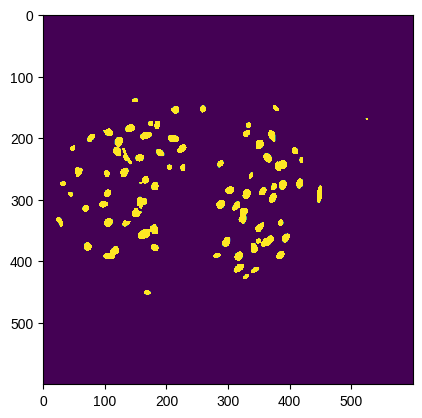

In [122]:
plt.imshow(binarized_max_footprints_conflict , cmap = 'viridis', vmin = 0,vmax = 0.01)

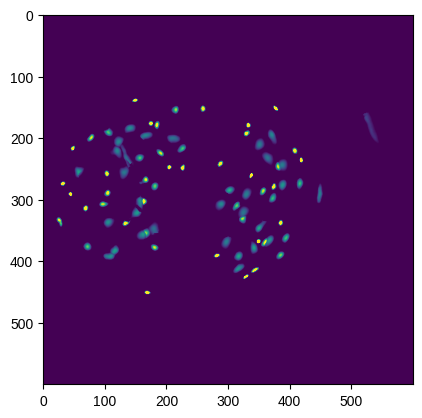

In [123]:
plt.imshow(footprints_conflict.max(axis = 0), cmap = 'viridis', vmin = 0,vmax = 0.02)

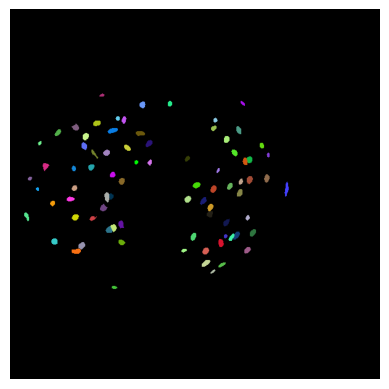

In [124]:
# Create a color image with the shape (600, 600, 3)
color_image = np.zeros((footprints_conflict.shape[1], footprints_conflict.shape[2], 3), dtype=np.uint8)


for i in range(footprints_conflict.shape[0]):
    np.random.seed(i)
    mask = footprints_conflict[i] > 0.005  # Find where the footprint is present
    color_image[mask] = np.random.randint(0, 256, 3)  # Assign the color to these positions

# Display the pseudo-colored image
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()

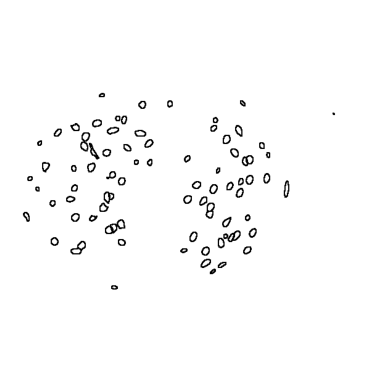

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel


color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 3), dtype=np.uint8) * 255

for i in range(footprints_conflict.shape[0]):
    np.random.seed(i)  # Seed for reproducibility
    
    # Extract the current footprint and find edges
    footprint = (footprints_conflict[i]>0.004).astype('int')
    edge_x = sobel(footprint, axis=0, mode='reflect')
    edge_y = sobel(footprint, axis=1, mode='reflect')
    edge_magnitude = np.hypot(edge_x, edge_y)
    
    # Create an edge mask
    edge_mask = edge_magnitude > edge_magnitude.mean() * 1.5  # Threshold can be adjusted
    
    # Generate a random color for the edges of this footprint
    color = [0,0,0]
    
    # Color the edges on the color image
    color_image[edge_mask] = color

# Display the pseudo-colored image
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()


In [126]:
conflict_path = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Conflict/"
satiation_path = "/scratch/09117/xz6783/minian/Satiation/Session Combined"
id_path = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Conflict/"
files = os.listdir(id_path)


In [127]:
dpath_conflict = os.path.join(conflict_path, animal_id)
pattern_conflict = os.path.join(dpath_conflict, "**", "minian")
minian_ds_path_conflict = glob.glob(pattern_conflict, recursive=True)[0]
if not os.path.exists(minian_ds_path_conflict):
    print(f"Minian dataset path {minian_ds_path_conflict} not found for animal ID {animal_id}")

minian_ds_conflict = open_minian(minian_ds_path_conflict)

# Assuming labels and unitid are as you defined
labels_conflict = minian_ds_conflict['C'].unit_labels.values
unitid_conflict = minian_ds_conflict['C'].unit_id.values

# Create the mapping directly from unit_id to label
unit_id_to_label_conflict = {u_id: label for label, u_id in zip(labels_conflict, unitid_conflict)}
mat_to_unitid_conflict = {label: u_id for label, u_id in zip(np.arange(1, len(unitid_conflict)+1), unitid_conflict)}

# Get minian_ds for satiation
dpath_satiation = os.path.join(satiation_path, animal_id)
pattern_satiation = os.path.join(dpath_satiation, "**", "minian")
minian_ds_path_satiation = glob.glob(pattern_satiation, recursive=True)[0]
if not os.path.exists(minian_ds_path_satiation):
    print(f"Minian dataset path {minian_ds_path_satiation} not found for animal ID {animal_id}")
minian_ds_satiation = open_minian(minian_ds_path_satiation)

# Assuming labels and unitid are as you defined
labels_satiation = minian_ds_satiation['C'].unit_labels.values
unitid_satiation = minian_ds_satiation['C'].unit_id.values

# Create the mapping directly from unit_id to label
unit_id_to_label_satiation = {u_id: label for label, u_id in zip(labels_satiation, unitid_satiation)}
mat_to_unitid_satiation = {label: u_id for label, u_id in zip(np.arange(1, len(unitid_satiation)+1), unitid_satiation)}

# Get mapping pickle file
pattern = os.path.join(cell_reg_output, f"{animal_id}*.mat")
matching_files = glob.glob(pattern)

# Load the DataFrame from the first matching file
mat_file_path = matching_files[0]
cell_to_index_map = mat73.loadmat(os.path.join(cell_reg_output, mat_file_path))['cell_registered_struct']['cell_to_index_map'].astype('int64')

# Matlab indexes starting from 1. Correct this for Python.
# Then NaN out the unmatched cells.
match_map = pd.DataFrame(cell_to_index_map)
match_map.columns = ['Conflict_cell_id', 'Satiation_cell_id']

# # Update DataFrame with mapped labels
match_map['Conflict_cell_id'] = match_map['Conflict_cell_id'].map(mat_to_unitid_conflict)
match_map['Satiation_cell_id'] = match_map['Satiation_cell_id'].map(mat_to_unitid_satiation)
match_map['Conflict_cell_id'] = match_map['Conflict_cell_id'].map(unit_id_to_label_conflict)
match_map['Satiation_cell_id'] = match_map['Satiation_cell_id'].map(unit_id_to_label_satiation)

# # Drop duplicate rows where 'Conflict' and 'Satiation' are the same
match_map = match_map.dropna().drop_duplicates(subset=['Conflict_cell_id', 'Satiation_cell_id'])

In [128]:
pattern_satiation

'/scratch/09117/xz6783/minian/Satiation/Session Combined/2Z4/**/minian'

In [95]:
cell_to_index_map_corrected = cell_to_index_map -1

In [96]:
cell_to_index_map_corrected

array([[  0,  -1],
       [  1,  -1],
       [  2,  -1],
       [  3,  -1],
       [  4,  -1],
       [  5,  -1],
       [  6,  -1],
       [ -1,  16],
       [  8,  -1],
       [  9,  -1],
       [ 10,  -1],
       [ 11,  -1],
       [ 12,  23],
       [ 13,  -1],
       [ 14,  33],
       [ 15,  -1],
       [ 16,  -1],
       [ 17,  -1],
       [ 18,  -1],
       [ 19,  38],
       [ 20,  -1],
       [ 21,  -1],
       [ 22,  -1],
       [ 23,  46],
       [ 24,  -1],
       [ 25,  50],
       [ 26,  -1],
       [ 27,  58],
       [ 28,  -1],
       [ 29,  -1],
       [ 30,  -1],
       [ 31,  -1],
       [ 32,  -1],
       [ 33,  -1],
       [ 34,  -1],
       [ 35,  65],
       [ 36,  -1],
       [ 37,  55],
       [ 38,  -1],
       [ 39,  -1],
       [ 40,  -1],
       [ 41,  82],
       [ 42,  -1],
       [ 43,  -1],
       [ 44,  -1],
       [ 45,  -1],
       [ 46,  -1],
       [ 47,  -1],
       [ 48,  -1],
       [ 49,  -1],
       [ 50,  -1],
       [ 52,  -1],
       [ 53,

In [97]:
animal_id = '2Z4'
session_satiation = 'satiation'
pattern_satiation  = os.path.join(cell_reg, animal_id, '**', f'{session_satiation }*.mat')
matching_files_satiation  = glob.glob(pattern_satiation )

# Load the DataFrame from the first matching file
mat_file_path_satiation  = matching_files_satiation [0]
footprints_satiation  = mat73.loadmat(mat_file_path_satiation)['footprints']

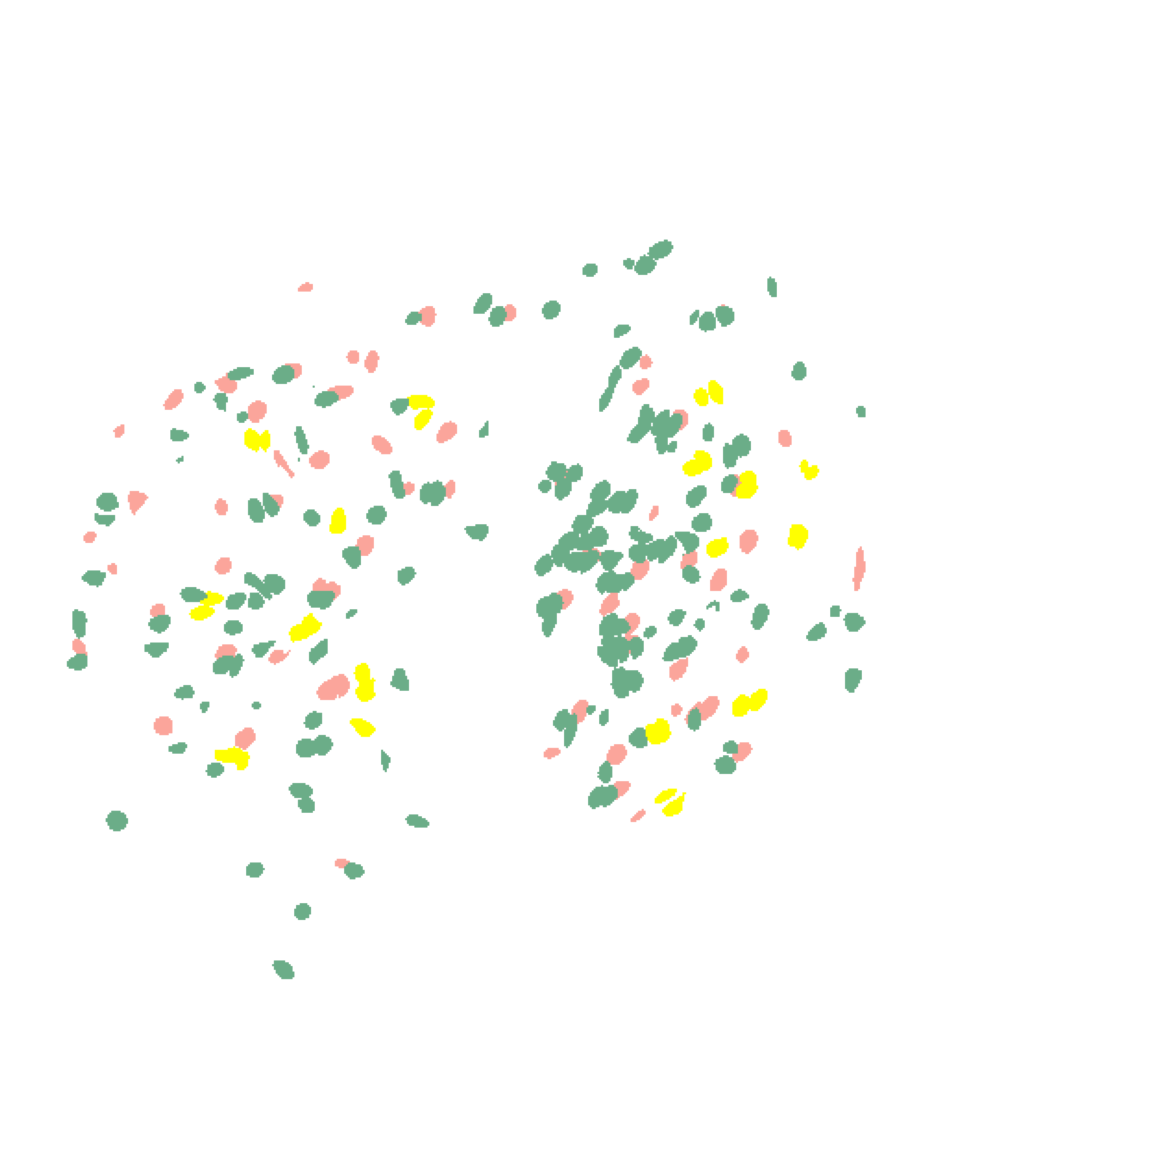

In [98]:

color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 4), dtype=np.uint8) * 255


for i in range(footprints_conflict.shape[0]):
    mask = footprints_conflict[i] > 0.005  # Find where the footprint is present
    if cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,0] == i)[0], 1] == -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('salmon')) * 255, [180]]))  # Assign the color to these positions
    elif cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,0] == i)[0], 1] != -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('yellow')) * 255, [255]]))
        
for i in range(footprints_satiation.shape[0]):
    mask = footprints_satiation[i] > 0.005  # Find where the footprint is present
    if cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,1] == i)[0], 0] == -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('seagreen')) * 255, [180]]))  # Assign the color to these positions
    elif cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,1] == i)[0], 0] != -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('yellow')) * 255, [255]]))

        # Display the pseudo-colored image
plt.figure(dpi=300)
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()

In [99]:
hungry_cells = pd.DataFrame()
hungry_cells['cell_id'] = np.concatenate([excited_hungry[excited_hungry.Animal_ID == animal_id].cell_id.values,
                               inhibited_hungry[inhibited_hungry.Animal_ID == animal_id].cell_id.values])
hungry_cells['cell_index'] = [np.where(unitid_satiation == i)[0][0] for i in hungry_cells['cell_id'].values]

In [100]:
hungry_cells

,cell_id,cell_index
0,51,47
1,113,102
2,130,117
3,132,119
4,154,140
5,18,16
6,49,45
7,52,48
8,104,93
9,151,137


In [101]:
satiation_cells = pd.DataFrame()
satiation_cells['cell_id'] = np.concatenate([excited_satiated[excited_satiated.Animal_ID == animal_id].cell_id.values,
                               inhibited_satiated[inhibited_satiated.Animal_ID == animal_id].cell_id.values])
satiation_cells['cell_index'] = [np.where(unitid_satiation == i)[0][0] for i in satiation_cells['cell_id'].values]

In [102]:
satiation_cells

,cell_id,cell_index
0,14,12
1,26,23
2,34,31
3,58,54
4,179,160


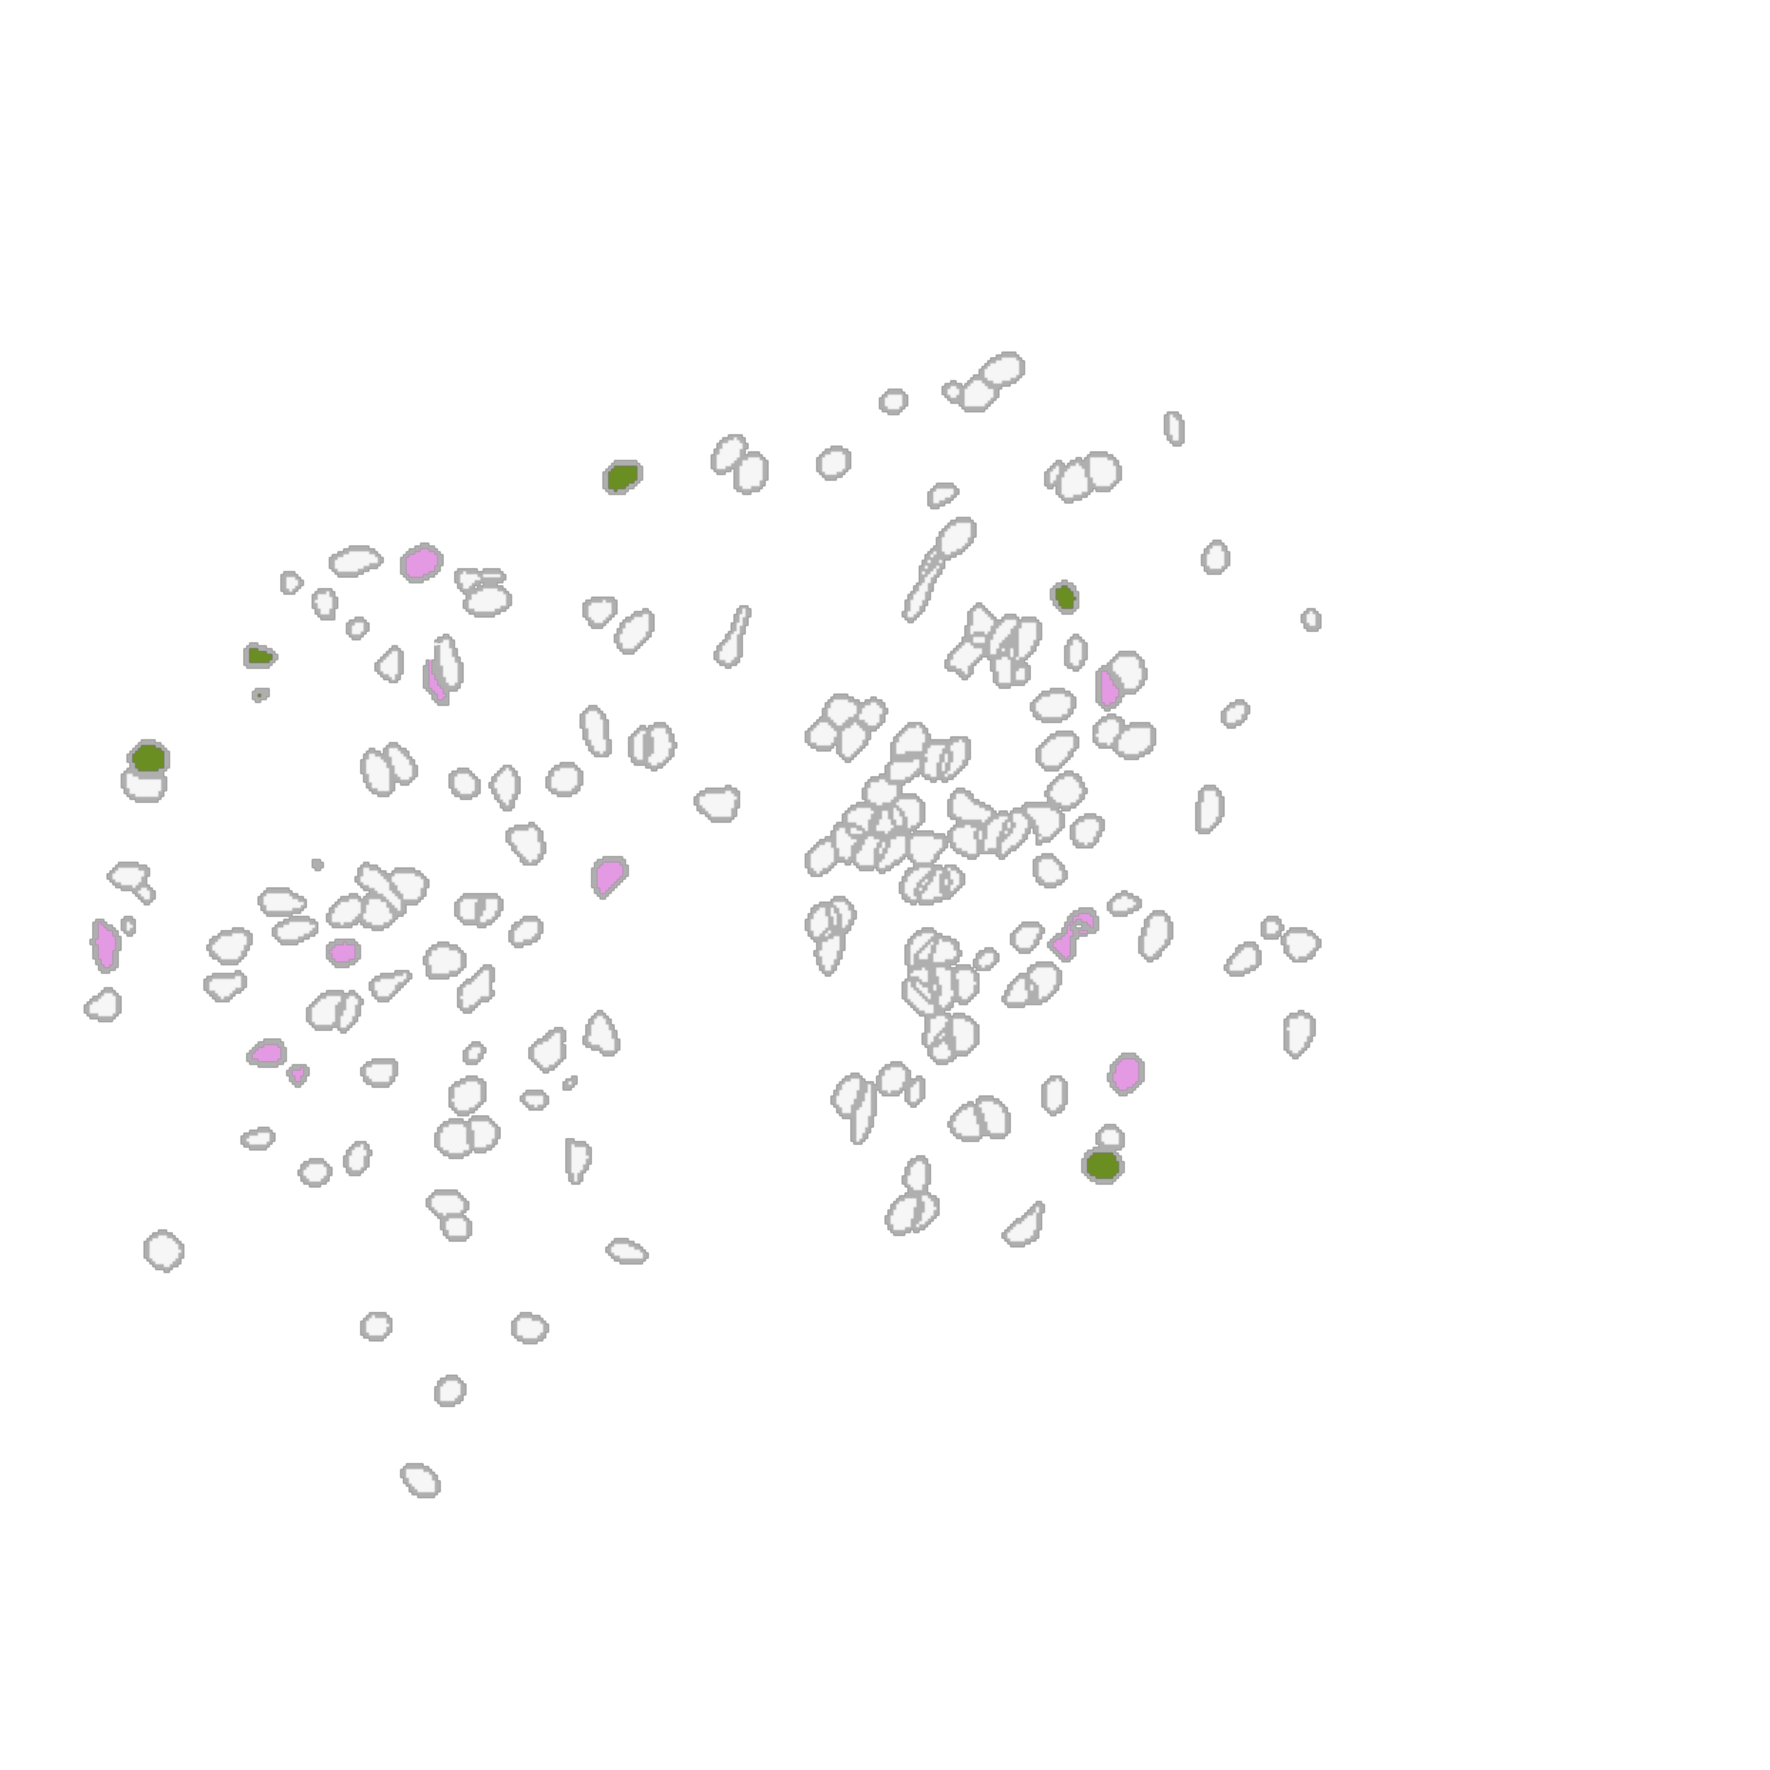

In [103]:
color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 4), dtype=np.uint8) * 255


    
for i in range(footprints_satiation.shape[0]):
    mask = footprints_satiation[i] > 0.004  # Find where the footprint is present
    if (i not in hungry_cells.cell_index.values) & (i not in satiation_cells.cell_index.values):
        color_image[mask] = (np.concatenate([np.array(to_rgb('lightgrey')) * 255, [50]]))
    elif (i in hungry_cells.cell_index.values) & (i in satiation_cells.cell_index.values):
        color_image[mask] = (np.concatenate([np.array(to_rgb('red')) * 255, [255]])) 
    elif i in hungry_cells.cell_index.values:
        color_image[mask] = (np.concatenate([np.array(to_rgb('orchid')) * 255, [180]]))  # Assign the color to these positions
    elif i in satiation_cells.cell_index.values:
        color_image[mask] = (np.concatenate([np.array(to_rgb('olivedrab')) * 255, [255]]))

        
for i in range(footprints_satiation.shape[0]):
    np.random.seed(i)  # Seed for reproducibility
    
    # Extract the current footprint and find edges
    footprint = (footprints_satiation[i]>0.004).astype('int')
    edge_x = sobel(footprint, axis=0, mode='reflect')
    edge_y = sobel(footprint, axis=1, mode='reflect')
    edge_magnitude = np.hypot(edge_x, edge_y)
    
    # Create an edge mask
    edge_mask = edge_magnitude > edge_magnitude.mean() + 2.5 # Threshold can be adjusted
    
    # Generate a random color for the edges of this footprint
    color = (np.concatenate([np.array(to_rgb('black')) * 255, [80]]))
    
    # Color the edges on the color image
    color_image[edge_mask] = color

        # Display the pseudo-colored image
plt.figure(figsize = (6, 6), dpi=300)
plt.imshow(color_image)
plt.axis('off')  # Hide the axes

plt.tight_layout()
plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig3/fig3_responsive_satiation_map.svg", transparent=True)

plt.show()

In [104]:
output_dir = '/scratch/09117/xz6783/Xu/PL_miniscope/PL/Analysis/Cat_Odor_Conflict/Conflict/analysis_output'

excited_safe = pd.read_csv(os.path.join(output_dir, 'Excited_Safe.csv'), index_col= 0)
inhibited_safe = pd.read_csv(os.path.join(output_dir, 'Inhibited_Safe.csv'), index_col= 0)

excited_threat = pd.read_csv(os.path.join(output_dir, 'Excited_Threat.csv'), index_col= 0)
inhibited_threat = pd.read_csv(os.path.join(output_dir, 'Inhibited_Threat.csv'), index_col= 0)

In [105]:
safe_cells = pd.DataFrame()
safe_cells['cell_id'] = np.concatenate([excited_safe[excited_safe.Animal_ID == animal_id].cell_id.values,
                               inhibited_safe[inhibited_safe.Animal_ID == animal_id].cell_id.values])
safe_cells['cell_index'] = [np.where(unitid_satiation == i)[0][0] for i in safe_cells['cell_id'].values]

In [106]:
safe_cells

,cell_id,cell_index
0,25,22
1,39,35


In [107]:
threat_cells = pd.DataFrame()
threat_cells['cell_id'] = np.concatenate([excited_threat[excited_threat.Animal_ID == animal_id].cell_id.values,
                               inhibited_threat[inhibited_threat.Animal_ID == animal_id].cell_id.values])
threat_cells['cell_index'] = [np.where(unitid_conflict == i)[0][0] for i in threat_cells['cell_id'].values]

In [108]:
threat_cells

,cell_id,cell_index
0,15,11
1,29,24
2,101,80


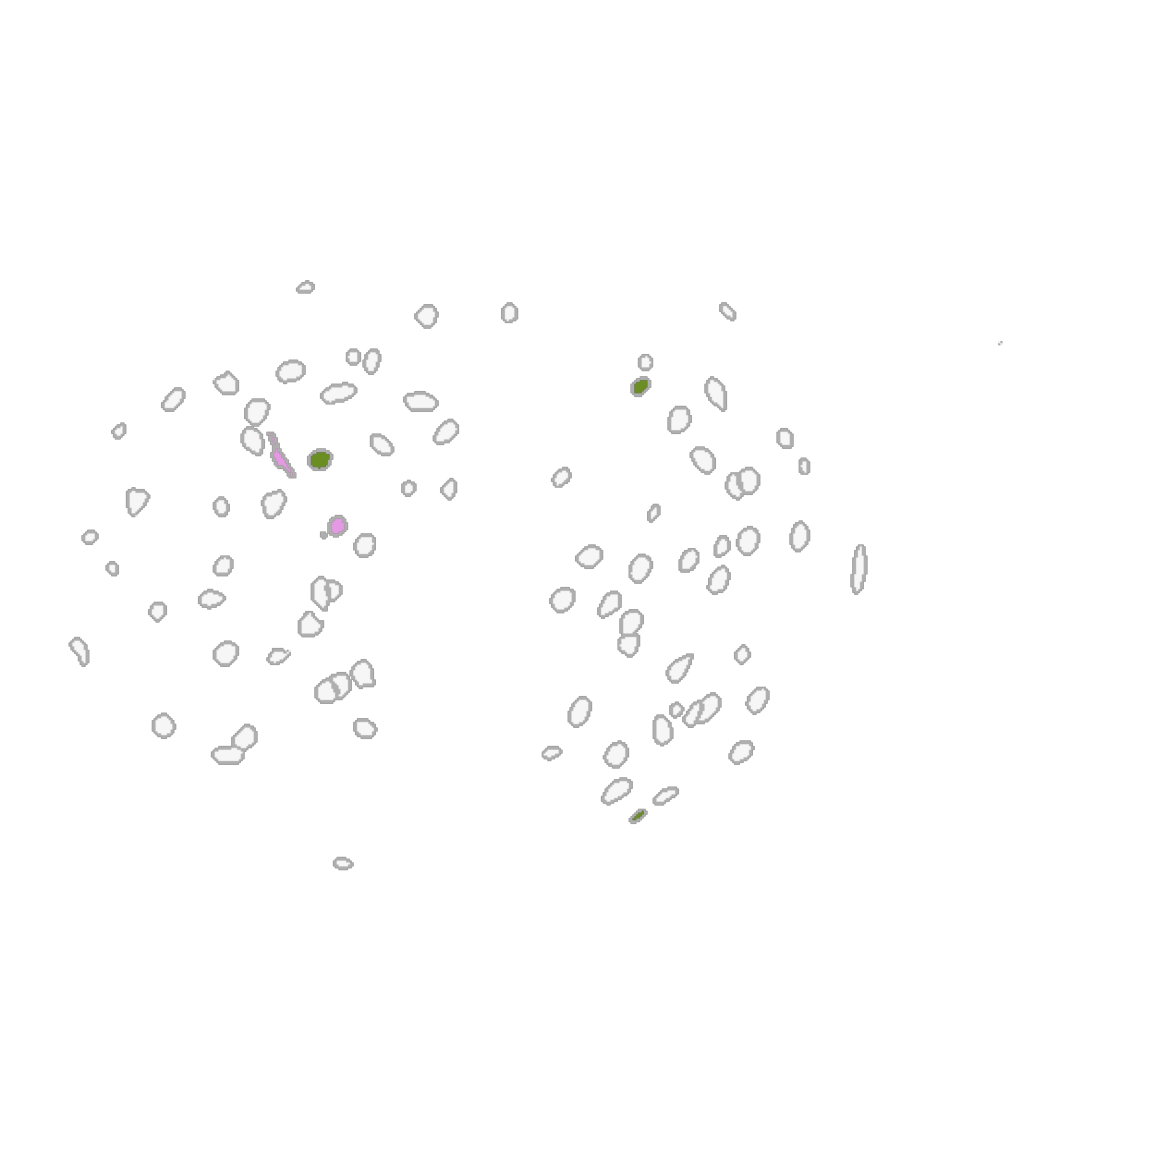

In [109]:
color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 4), dtype=np.uint8) * 255


    
for i in range(footprints_conflict.shape[0]):
    mask = footprints_conflict[i] > 0.004  # Find where the footprint is present
    if (i not in safe_cells.cell_index.values) & (i not in threat_cells.cell_index.values):
        color_image[mask] = (np.concatenate([np.array(to_rgb('lightgrey')) * 255, [50]]))
    elif (i in safe_cells.cell_index.values) & (i in threat_cells.cell_index.values):
        color_image[mask] = (np.concatenate([np.array(to_rgb('red')) * 255, [255]])) 
    elif i in safe_cells.cell_index.values:
        color_image[mask] = (np.concatenate([np.array(to_rgb('orchid')) * 255, [180]]))  # Assign the color to these positions
    elif i in threat_cells.cell_index.values:
        color_image[mask] = (np.concatenate([np.array(to_rgb('olivedrab')) * 255, [255]]))

        
for i in range(footprints_conflict.shape[0]):
    np.random.seed(i)  # Seed for reproducibility
    
    # Extract the current footprint and find edges
    footprint = (footprints_conflict[i]>0.004).astype('int')
    edge_x = sobel(footprint, axis=0, mode='reflect')
    edge_y = sobel(footprint, axis=1, mode='reflect')
    edge_magnitude = np.hypot(edge_x, edge_y)
    
    # Create an edge mask
    edge_mask = edge_magnitude > edge_magnitude.mean() + 2.5 # Threshold can be adjusted
    
    # Generate a random color for the edges of this footprint
    color = (np.concatenate([np.array(to_rgb('black')) * 255, [80]]))
    
    # Color the edges on the color image
    color_image[edge_mask] = color

        # Display the pseudo-colored image
plt.figure(dpi=300)
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()

In [110]:
excited_safe

,Animal_ID,cell_id,0,1,2,3,4,5,6,7,...,56,57,58,59,60,61,62,63,64,65
25,2I5,32,1.108853,0.987538,0.857445,0.755408,0.795807,0.905021,1.029256,0.644166,...,4.974760,4.389289,4.036704,4.118281,4.324436,4.487934,4.583896,4.551206,4.251973,3.776249
51,2I5,65,0.343585,0.095837,-0.005402,-0.011357,-0.181616,-0.277330,-0.136653,0.461430,...,0.962751,0.650051,0.342411,0.058090,-0.109020,0.124273,0.351138,0.292985,0.010374,-0.284561
87,2I5,108,-0.387386,-0.675438,-0.852637,-0.940274,-0.962703,-0.505478,-0.374638,-0.709804,...,4.081313,3.460774,2.955896,2.485824,1.961377,1.470081,1.149575,0.994635,0.944417,1.527729
112,2I5,140,-2.101691,-1.886837,-1.508167,-1.039049,-0.519923,0.245878,1.019751,1.632864,...,7.970423,7.612327,7.080406,6.737332,6.825820,7.094482,7.214289,6.918062,6.424709,5.868579
129,2I5,158,1.443592,1.225093,0.746673,0.389296,0.542245,0.750496,0.707437,0.509055,...,13.288875,13.929128,14.259528,14.204870,14.201383,13.783143,12.854280,11.946974,11.068084,10.147389
137,2I5,166,1.697678,0.978376,0.523510,0.216970,-0.018956,-0.190283,0.386366,1.069032,...,1.870301,2.051968,2.024402,2.270049,3.203666,4.042070,4.580707,4.558466,4.549411,4.247439
139,1H6,2,2.052693,1.787908,1.496128,1.508665,0.877056,0.279705,0.005682,0.014747,...,17.998694,18.202177,18.037382,16.866651,15.499522,14.088219,12.498251,11.329036,10.462422,9.316370
166,1H6,65,-0.828489,-0.528834,-0.137417,-0.223824,-0.183163,-0.370161,-0.862678,-1.198120,...,11.225380,10.684746,10.178852,9.789661,9.454459,9.355983,9.909959,10.242197,9.813059,9.364370
193,6S5,25,-1.415102,-1.669023,-1.623826,0.080655,0.403797,0.739345,2.132414,2.130661,...,24.184180,23.782470,23.741059,24.206663,24.989141,25.612725,24.867742,23.652024,22.346780,20.894356
200,6S5,32,0.970396,0.785155,0.539228,0.600788,0.712164,0.535207,0.372307,0.092900,...,9.913339,9.564410,9.074245,9.000800,8.886603,8.799540,9.074447,9.696515,9.882769,9.804417


In [129]:
animal_id = '6M6'
session_conflict = 'conflict'
pattern_conflict  = os.path.join(cell_reg, animal_id, '**', f'{session_conflict }*.mat')
matching_files_conflict  = glob.glob(pattern_conflict )

# Load the DataFrame from the first matching file
mat_file_path_conflict  = matching_files_conflict [0]
footprints_conflict  = mat73.loadmat(mat_file_path_conflict)['footprints']


In [130]:
binarized_max_footprints_conflict  = (footprints_conflict.max(axis = 0)>0.004).astype('int')

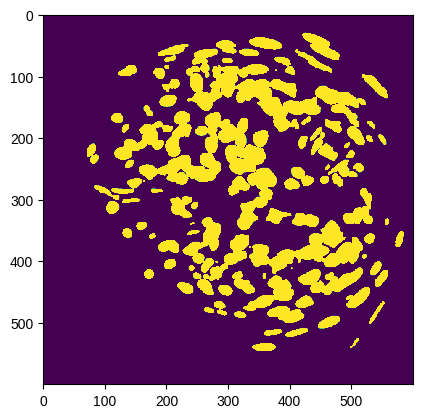

In [131]:
plt.imshow(binarized_max_footprints_conflict , cmap = 'viridis', vmin = 0,vmax = 0.01)

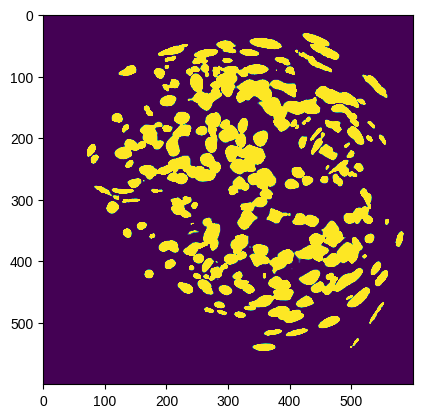

In [132]:
plt.imshow(footprints_conflict.max(axis = 0), cmap = 'viridis', vmin = 0,vmax = 0.02)

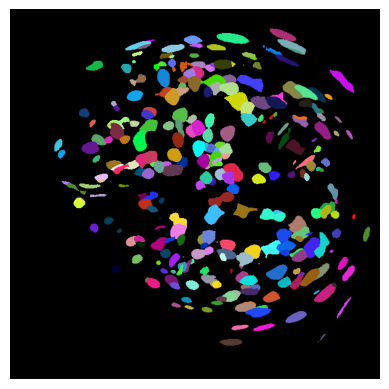

In [133]:
# Create a color image with the shape (600, 600, 3)
color_image = np.zeros((footprints_conflict.shape[1], footprints_conflict.shape[2], 3), dtype=np.uint8)


for i in range(footprints_conflict.shape[0]):
    np.random.seed(i)
    mask = footprints_conflict[i] > 0.001  # Find where the footprint is present
    color_image[mask] = np.random.randint(0, 256, 3)  # Assign the color to these positions

# Display the pseudo-colored image
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()

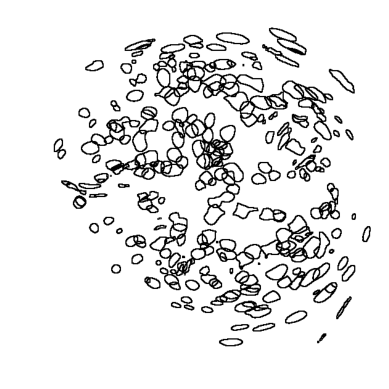

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel


color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 3), dtype=np.uint8) * 255

for i in range(footprints_conflict.shape[0]):
    np.random.seed(i)  # Seed for reproducibility
    
    # Extract the current footprint and find edges
    footprint = (footprints_conflict[i]>0.001).astype('int')
    edge_x = sobel(footprint, axis=0, mode='reflect')
    edge_y = sobel(footprint, axis=1, mode='reflect')
    edge_magnitude = np.hypot(edge_x, edge_y)
    
    # Create an edge mask
    edge_mask = edge_magnitude > edge_magnitude.mean() * 1.5  # Threshold can be adjusted
    
    # Generate a random color for the edges of this footprint
    color = [0,0,0]
    
    # Color the edges on the color image
    color_image[edge_mask] = color

# Display the pseudo-colored image
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()


In [135]:
conflict_path = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Conflict/"
satiation_path = "/scratch/09117/xz6783/minian/Satiation/Session Combined"
id_path = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Conflict/"
files = os.listdir(id_path)


In [140]:
dpath_conflict = os.path.join(conflict_path, animal_id)
pattern_conflict = os.path.join(dpath_conflict, "**", "minian")
minian_ds_path_conflict = glob.glob(pattern_conflict, recursive=True)[0]
if not os.path.exists(minian_ds_path_conflict):
    print(f"Minian dataset path {minian_ds_path_conflict} not found for animal ID {animal_id}")

minian_ds_conflict = open_minian(minian_ds_path_conflict)

# Assuming labels and unitid are as you defined
labels_conflict = minian_ds_conflict['C'].unit_labels.values
unitid_conflict = minian_ds_conflict['C'].unit_id.values

# Create the mapping directly from unit_id to label
unit_id_to_label_conflict = {u_id: label for label, u_id in zip(labels_conflict, unitid_conflict)}
mat_to_unitid_conflict = {label: u_id for label, u_id in zip(np.arange(1, len(unitid_conflict)+1), unitid_conflict)}

# Get minian_ds for satiation
dpath_satiation = os.path.join(satiation_path, animal_id)
pattern_satiation = os.path.join(dpath_satiation, "**", "minian")
minian_ds_path_satiation = glob.glob(pattern_satiation, recursive=True)[0]
if not os.path.exists(minian_ds_path_satiation):
    print(f"Minian dataset path {minian_ds_path_satiation} not found for animal ID {animal_id}")
minian_ds_satiation = open_minian(minian_ds_path_satiation)

# Assuming labels and unitid are as you defined
labels_satiation = minian_ds_satiation['C'].unit_labels.values
unitid_satiation = minian_ds_satiation['C'].unit_id.values

# Create the mapping directly from unit_id to label
unit_id_to_label_satiation = {u_id: label for label, u_id in zip(labels_satiation, unitid_satiation)}
mat_to_unitid_satiation = {label: u_id for label, u_id in zip(np.arange(1, len(unitid_satiation)+1), unitid_satiation)}

# Get mapping pickle file
pattern = os.path.join(cell_reg_output, f"{animal_id}*.mat")
matching_files = glob.glob(pattern)

# Load the DataFrame from the first matching file
mat_file_path = matching_files[0]
cell_to_index_map = mat73.loadmat(os.path.join(cell_reg_output, mat_file_path))['cell_registered_struct']['cell_to_index_map'].astype('int64')

# Matlab indexes starting from 1. Correct this for Python.
# Then NaN out the unmatched cells.
match_map = pd.DataFrame(cell_to_index_map)
match_map.columns = ['Conflict_cell_id', 'Satiation_cell_id']

# # Update DataFrame with mapped labels
match_map['Conflict_cell_id'] = match_map['Conflict_cell_id'].map(mat_to_unitid_conflict)
match_map['Satiation_cell_id'] = match_map['Satiation_cell_id'].map(mat_to_unitid_satiation)
match_map['Conflict_cell_id'] = match_map['Conflict_cell_id'].map(unit_id_to_label_conflict)
match_map['Satiation_cell_id'] = match_map['Satiation_cell_id'].map(unit_id_to_label_satiation)

# # Drop duplicate rows where 'Conflict' and 'Satiation' are the same
match_map = match_map.dropna().drop_duplicates(subset=['Conflict_cell_id', 'Satiation_cell_id'])

In [141]:
pattern_satiation

'/scratch/09117/xz6783/minian/Satiation/Session Combined/6M6/**/minian'

In [142]:
cell_to_index_map_corrected = cell_to_index_map -1

In [143]:
cell_to_index_map_corrected

array([[  0,   0],
       [  1,  -1],
       [  2,  -1],
       [  3,  -1],
       [  4,  -1],
       [  5,  -1],
       [  6,  -1],
       [  7,  -1],
       [  8,  -1],
       [  9,  -1],
       [ 10,  -1],
       [ 11,  -1],
       [ 12,  -1],
       [ 13,  -1],
       [ 14,  -1],
       [ 15,  -1],
       [ 16,  -1],
       [ 17,  -1],
       [ 18,  -1],
       [ 19,  -1],
       [ 20,  -1],
       [ 21,  -1],
       [ 22,  -1],
       [ 23,  -1],
       [ 24,  -1],
       [ 25,  -1],
       [ 26,  -1],
       [ 27,  -1],
       [ 28,  -1],
       [ 29,  -1],
       [ 30,  -1],
       [ 31,  -1],
       [ 32,  -1],
       [ 33,   3],
       [ 34,  -1],
       [ 35,  -1],
       [ 36,  -1],
       [ 37,  -1],
       [ 38,  -1],
       [ 39,  -1],
       [ 40,   4],
       [ 41,  -1],
       [ 42,  -1],
       [ 43,   5],
       [ 44,  -1],
       [ 45,  -1],
       [ 46,   6],
       [ 47,  -1],
       [ 48,  -1],
       [ 49,  -1],
       [ 50,  -1],
       [ 51,  -1],
       [ 52,

In [144]:
animal_id = '6M6'
session_satiation = 'satiation'
pattern_satiation  = os.path.join(cell_reg, animal_id, '**', f'{session_satiation }*.mat')
matching_files_satiation  = glob.glob(pattern_satiation )

# Load the DataFrame from the first matching file
mat_file_path_satiation  = matching_files_satiation [0]
footprints_satiation  = mat73.loadmat(mat_file_path_satiation)['footprints']

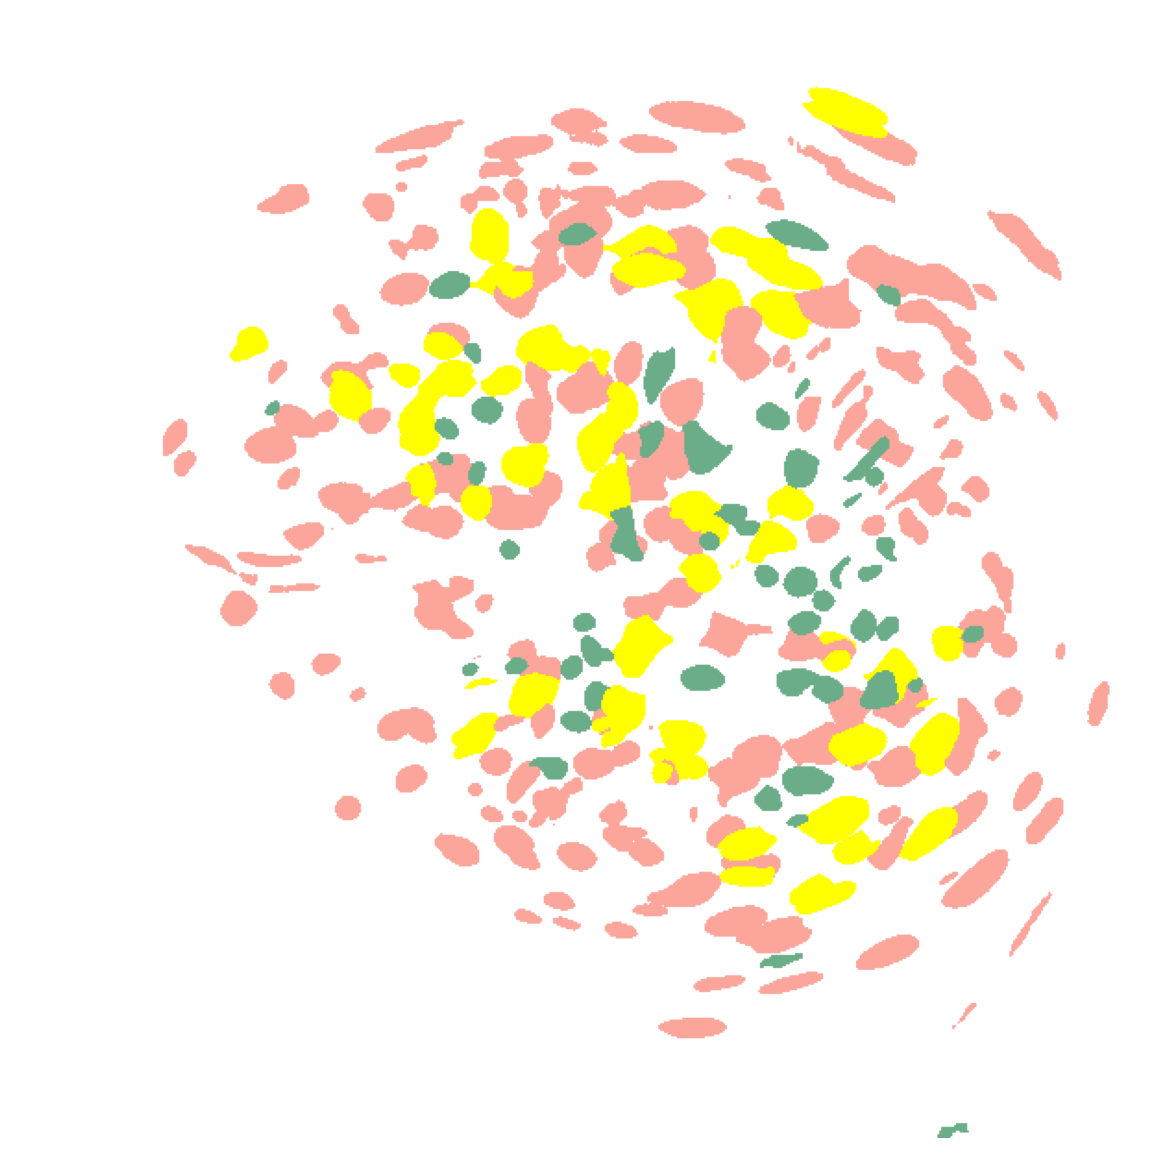

In [145]:

color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 4), dtype=np.uint8) * 255


for i in range(footprints_conflict.shape[0]):
    mask = footprints_conflict[i] > 0.005  # Find where the footprint is present
    if cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,0] == i)[0], 1] == -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('salmon')) * 255, [180]]))  # Assign the color to these positions
    elif cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,0] == i)[0], 1] != -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('yellow')) * 255, [255]]))
        
for i in range(footprints_satiation.shape[0]):
    mask = footprints_satiation[i] > 0.005  # Find where the footprint is present
    if cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,1] == i)[0], 0] == -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('seagreen')) * 255, [180]]))  # Assign the color to these positions
    elif cell_to_index_map_corrected[np.where(cell_to_index_map_corrected[:,1] == i)[0], 0] != -1:
        color_image[mask] = (np.concatenate([np.array(to_rgb('yellow')) * 255, [255]]))

        # Display the pseudo-colored image
plt.figure(dpi=300)
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()

In [146]:
hungry_cells = pd.DataFrame()
hungry_cells['cell_id'] = np.concatenate([excited_hungry[excited_hungry.Animal_ID == animal_id].cell_id.values,
                               inhibited_hungry[inhibited_hungry.Animal_ID == animal_id].cell_id.values])
hungry_cells['cell_index'] = [np.where(unitid_satiation == i)[0][0] for i in hungry_cells['cell_id'].values]

In [147]:
hungry_cells

,cell_id,cell_index
0,7,5
1,70,62
2,80,71
3,87,77
4,33,26
5,61,54


In [148]:
satiation_cells = pd.DataFrame()
satiation_cells['cell_id'] = np.concatenate([excited_satiated[excited_satiated.Animal_ID == animal_id].cell_id.values,
                               inhibited_satiated[inhibited_satiated.Animal_ID == animal_id].cell_id.values])
satiation_cells['cell_index'] = [np.where(unitid_satiation == i)[0][0] for i in satiation_cells['cell_id'].values]

In [149]:
satiation_cells

,cell_id,cell_index
0,55,48
1,95,85
2,68,61
3,75,67


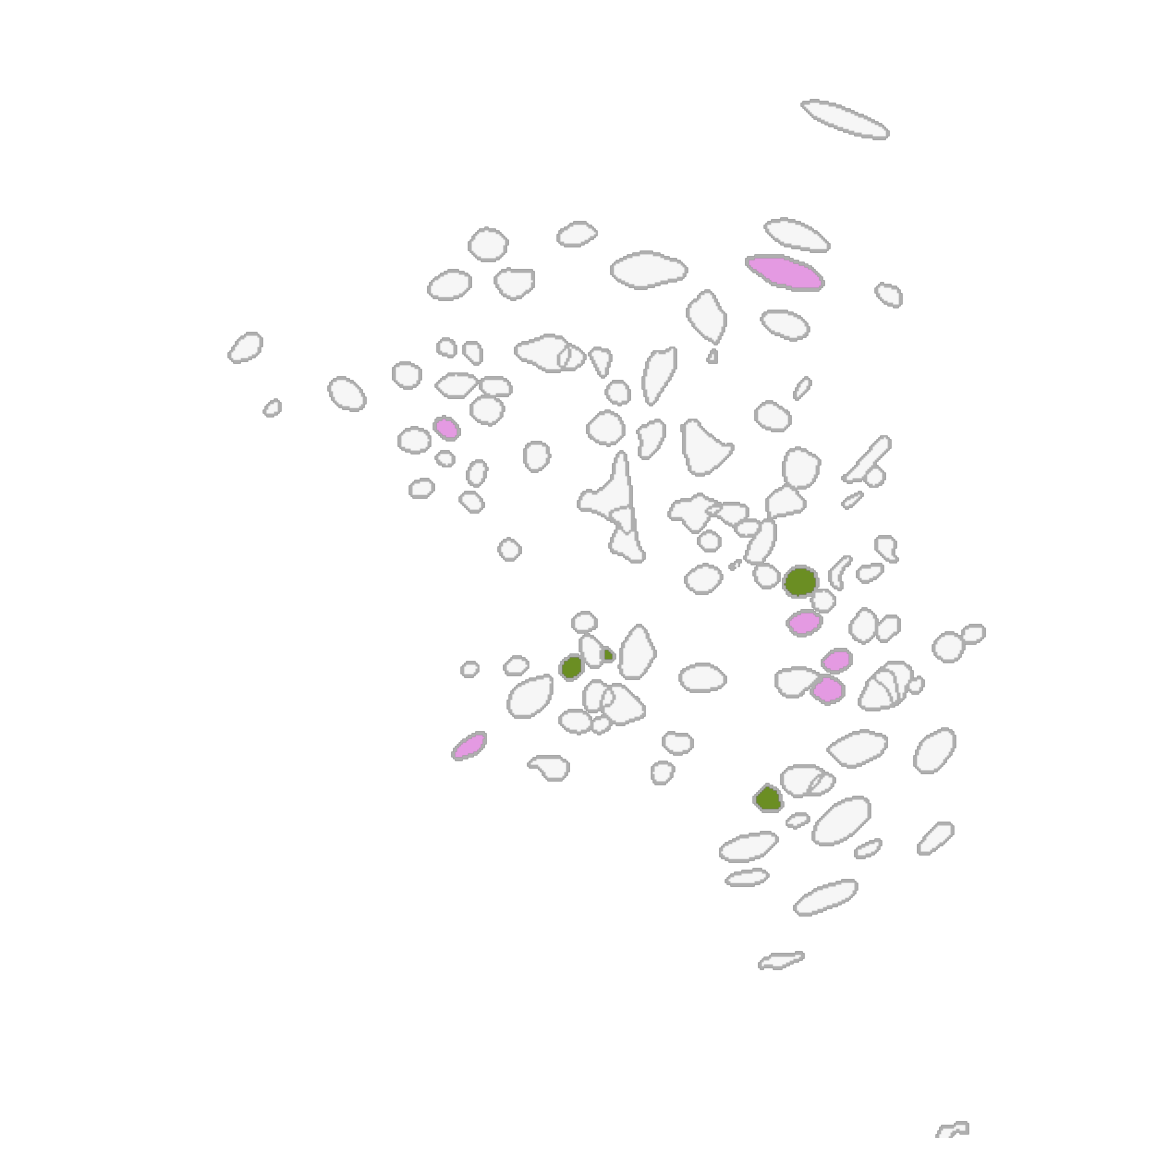

In [150]:
color_image = np.ones((footprints_satiation.shape[1], footprints_satiation.shape[2], 4), dtype=np.uint8) * 255


    
for i in range(footprints_satiation.shape[0]):
    mask = footprints_satiation[i] > 0.001  # Find where the footprint is present
    if (i not in hungry_cells.cell_index.values) & (i not in satiation_cells.cell_index.values):
        color_image[mask] = (np.concatenate([np.array(to_rgb('lightgrey')) * 255, [50]]))
    elif (i in hungry_cells.cell_index.values) & (i in satiation_cells.cell_index.values):
        color_image[mask] = (np.concatenate([np.array(to_rgb('red')) * 255, [255]])) 
    elif i in hungry_cells.cell_index.values:
        color_image[mask] = (np.concatenate([np.array(to_rgb('orchid')) * 255, [180]]))  # Assign the color to these positions
    elif i in satiation_cells.cell_index.values:
        color_image[mask] = (np.concatenate([np.array(to_rgb('olivedrab')) * 255, [255]]))

        
for i in range(footprints_satiation.shape[0]):
    np.random.seed(i)  # Seed for reproducibility
    
    # Extract the current footprint and find edges
    footprint = (footprints_satiation[i]>0.004).astype('int')
    edge_x = sobel(footprint, axis=0, mode='reflect')
    edge_y = sobel(footprint, axis=1, mode='reflect')
    edge_magnitude = np.hypot(edge_x, edge_y)
    
    # Create an edge mask
    edge_mask = edge_magnitude > edge_magnitude.mean() + 2.5 # Threshold can be adjusted
    
    # Generate a random color for the edges of this footprint
    color = (np.concatenate([np.array(to_rgb('black')) * 255, [80]]))
    
    # Color the edges on the color image
    color_image[edge_mask] = color

        # Display the pseudo-colored image
plt.figure(dpi=300)
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.show()

In [151]:
output_dir = '/scratch/09117/xz6783/Xu/PL_miniscope/PL/Analysis/Cat_Odor_Conflict/Conflict/analysis_output'

excited_safe = pd.read_csv(os.path.join(output_dir, 'Excited_Safe.csv'), index_col= 0)
inhibited_safe = pd.read_csv(os.path.join(output_dir, 'Inhibited_Safe.csv'), index_col= 0)

excited_threat = pd.read_csv(os.path.join(output_dir, 'Excited_Threat.csv'), index_col= 0)
inhibited_threat = pd.read_csv(os.path.join(output_dir, 'Inhibited_Threat.csv'), index_col= 0)

In [152]:
safe_cells = pd.DataFrame()
safe_cells['cell_id'] = np.concatenate([excited_safe[excited_safe.Animal_ID == animal_id].cell_id.values,
                               inhibited_safe[inhibited_safe.Animal_ID == animal_id].cell_id.values])
safe_cells['cell_index'] = [np.where(unitid_conflict == i)[0][0] for i in safe_cells['cell_id'].values]

In [153]:
safe_cells

,cell_id,cell_index
0,113,73
1,104,66
2,136,91
3,160,109
4,285,196
5,76,50
6,138,93
7,202,141
8,323,226
9,338,238


In [154]:
threat_cells = pd.DataFrame()
threat_cells['cell_id'] = np.concatenate([excited_threat[excited_threat.Animal_ID == animal_id].cell_id.values,
                               inhibited_threat[inhibited_threat.Animal_ID == animal_id].cell_id.values])
threat_cells['cell_index'] = [np.where(unitid_conflict == i)[0][0] for i in threat_cells['cell_id'].values]

In [155]:
threat_cells

,cell_id,cell_index
0,108,68
1,136,91
2,385,268
3,56,34
4,311,216


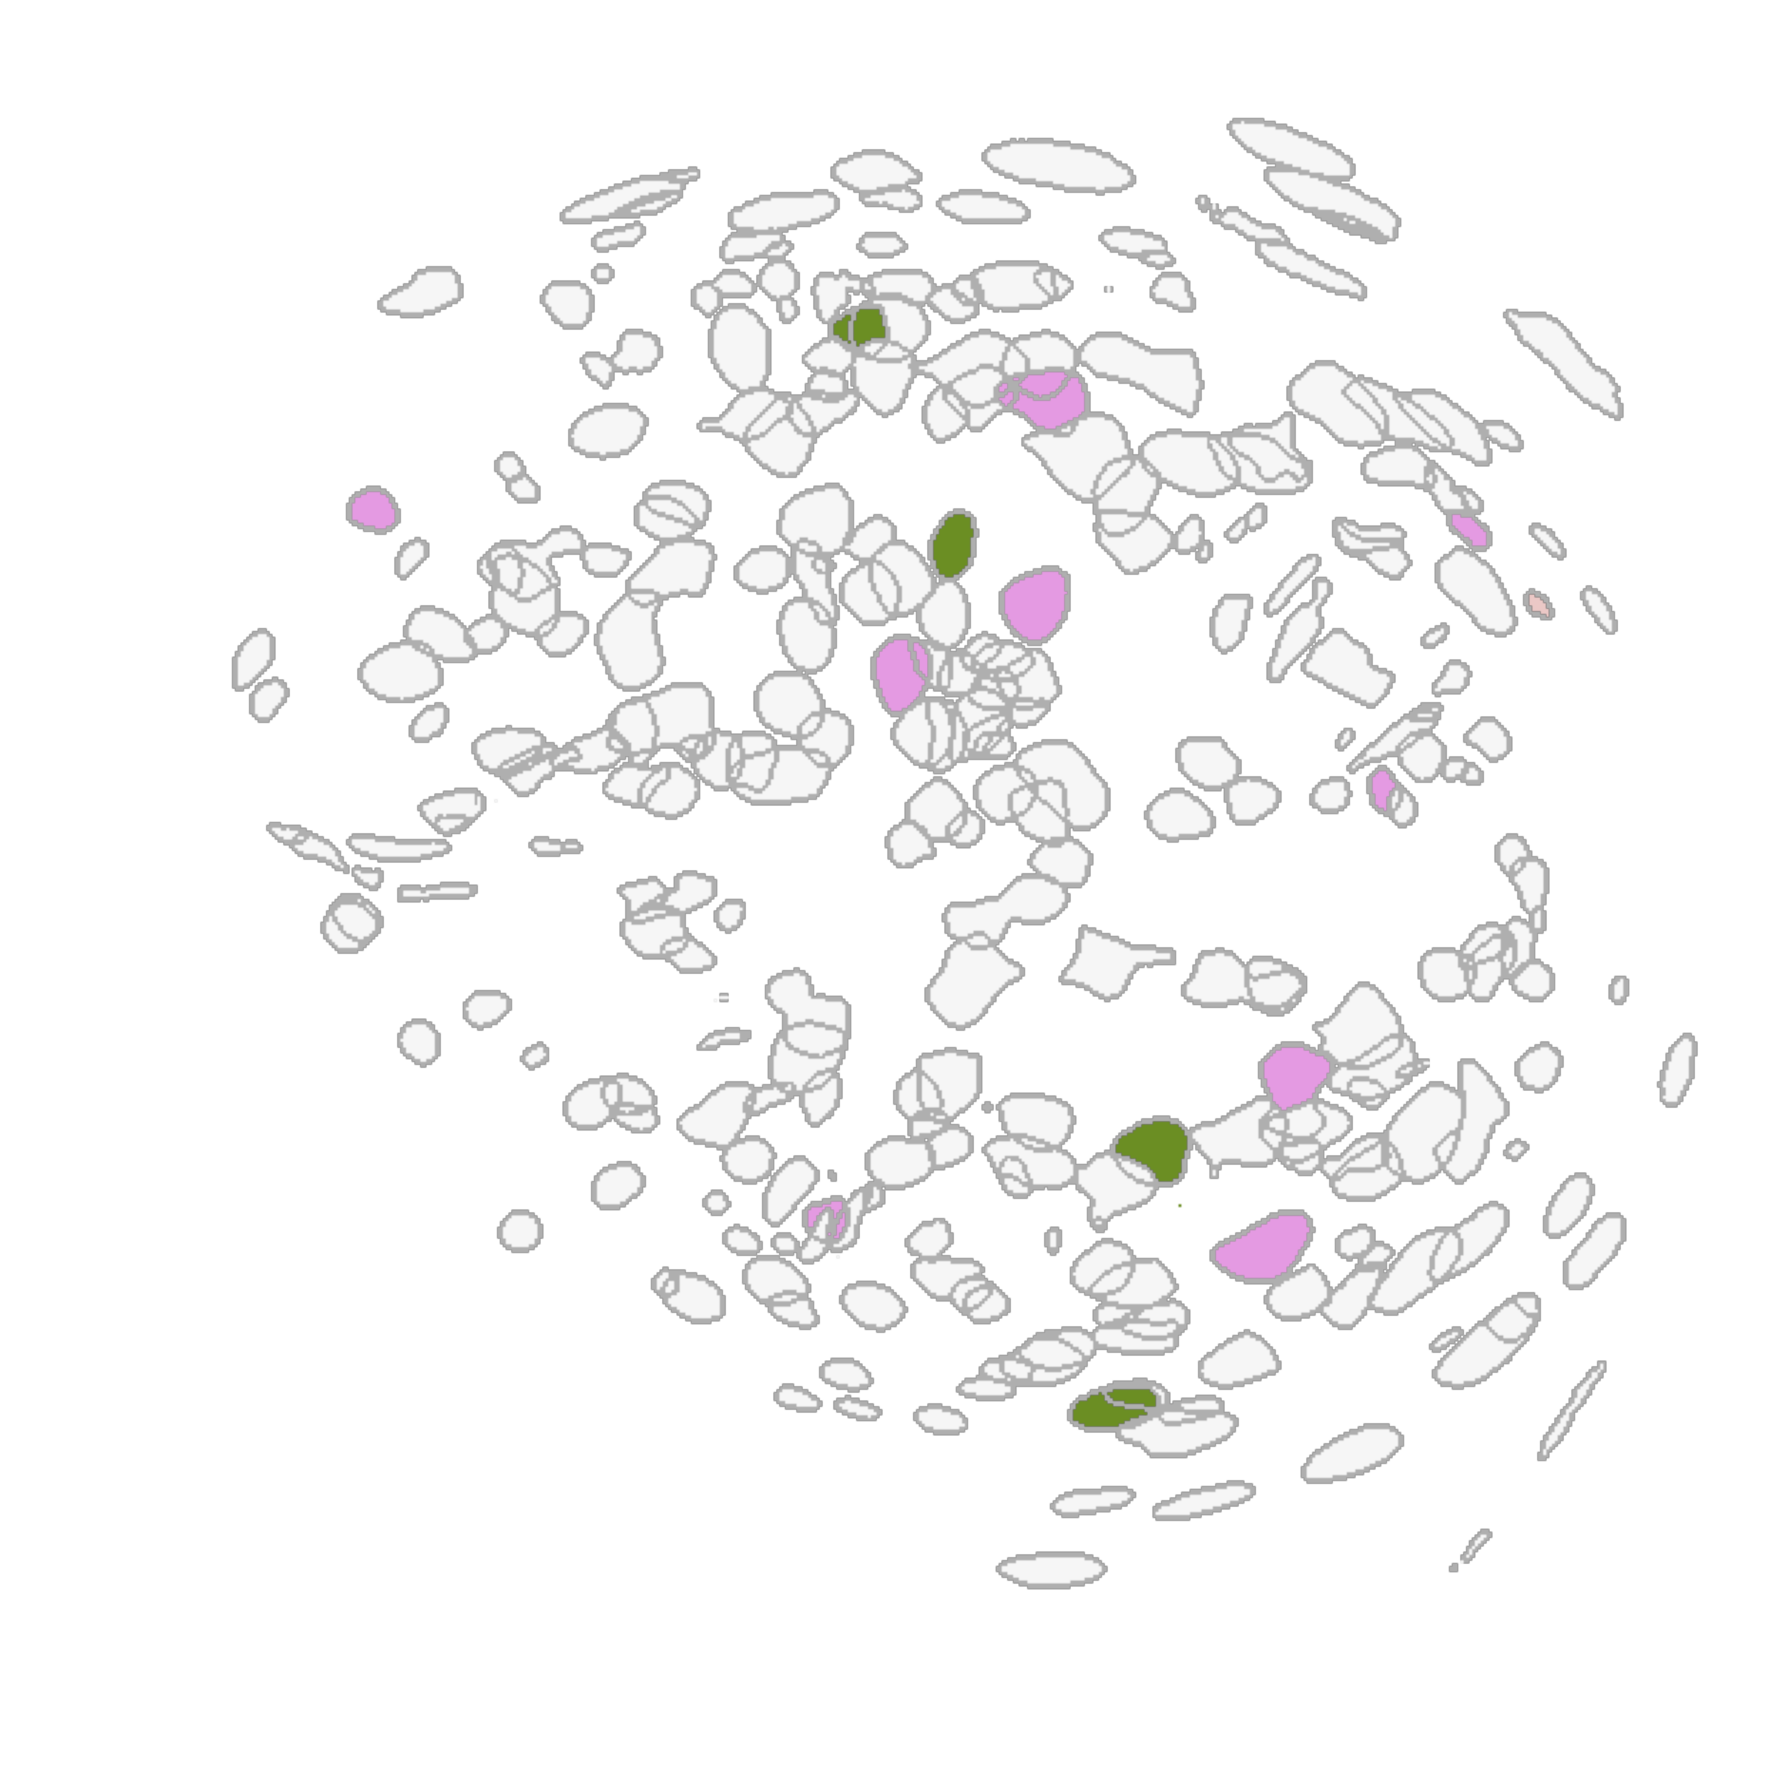

In [156]:
color_image = np.ones((footprints_conflict.shape[1], footprints_conflict.shape[2], 4), dtype=np.uint8) * 255


    
for i in range(footprints_conflict.shape[0]):
    mask = footprints_conflict[i] > 0.004  # Find where the footprint is present
    if (i not in safe_cells.cell_index.values) & (i not in threat_cells.cell_index.values):
        color_image[mask] = (np.concatenate([np.array(to_rgb('lightgrey')) * 255, [50]]))
    elif (i in safe_cells.cell_index.values) & (i in threat_cells.cell_index.values):
        color_image[mask] = (np.concatenate([np.array(to_rgb('#ebc8c6')) * 255, [255]])) 
    elif i in safe_cells.cell_index.values:
        color_image[mask] = (np.concatenate([np.array(to_rgb('orchid')) * 255, [180]]))  # Assign the color to these positions
    elif i in threat_cells.cell_index.values:
        color_image[mask] = (np.concatenate([np.array(to_rgb('olivedrab')) * 255, [255]]))

        
for i in range(footprints_conflict.shape[0]):
    np.random.seed(i)  # Seed for reproducibility
    
    # Extract the current footprint and find edges
    footprint = (footprints_conflict[i]>0.004).astype('int')
    edge_x = sobel(footprint, axis=0, mode='reflect')
    edge_y = sobel(footprint, axis=1, mode='reflect')
    edge_magnitude = np.hypot(edge_x, edge_y)
    
    # Create an edge mask
    edge_mask = edge_magnitude > edge_magnitude.mean() + 2.5 # Threshold can be adjusted
    
    # Generate a random color for the edges of this footprint
    color = (np.concatenate([np.array(to_rgb('black')) * 255, [80]]))
    
    # Color the edges on the color image
    color_image[edge_mask] = color

        # Display the pseudo-colored image
plt.figure(figsize = (6,6), dpi=300)
plt.imshow(color_image)
plt.axis('off')  # Hide the axes
plt.tight_layout()
plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig3/fig3_responsive_threat_map.svg", transparent=True)

plt.show()

In [188]:
0 in satiation_cells.cell_index.values

False

In [184]:
satiation_cells.cell_index

0     12
1     23
2     31
3     54
4    160
Name: cell_index, dtype: int64

In [6]:
# conflict_path = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Conflict/"
# satiation_path = "/scratch/09117/xz6783/minian/Satiation/Session Combined"
# id_path = "/scratch/09117/xz6783/minian/Cat_Odor_Conflict/Conflict/"
# files = os.listdir(id_path)

# animal_ids = [file for file in files if os.path.isdir(os.path.join(id_path, file)) and len(file) == 3 and file[0].isdigit()]

# print(len(animal_ids))
# animal_ids

14


['2Z4',
 '6S5',
 '9M6',
 '2I5',
 '7H6',
 '1S5',
 '7M6',
 '7B6',
 '8H6',
 '2N6',
 '1H6',
 '5B6',
 '6H6',
 '6M6']

In [62]:
for animal_id in animal_ids:
    # Get minian_ds for conflict
    dpath_conflict = os.path.join(conflict_path, animal_id)
    pattern_conflict = os.path.join(dpath_conflict, "**", "minian")
    minian_ds_path_conflict = glob.glob(pattern_conflict, recursive=True)[0]
    if not os.path.exists(minian_ds_path_conflict):
        print(f"Minian dataset path {minian_ds_path_conflict} not found for animal ID {animal_id}")

    minian_ds_conflict = open_minian(minian_ds_path_conflict)
    
    # Assuming labels and unitid are as you defined
    labels_conflict = minian_ds_conflict['C'].unit_labels.values
    unitid_conflict = minian_ds_conflict['C'].unit_id.values

    # Create the mapping directly from unit_id to label
    unit_id_to_label_conflict = {u_id: label for label, u_id in zip(labels_conflict, unitid_conflict)}
    
    # Get minian_ds for satiation
    dpath_satiation = os.path.join(satiation_path, animal_id)
    pattern_satiation = os.path.join(dpath_satiation, "**", "minian")
    minian_ds_path_satiation = glob.glob(pattern_satiation, recursive=True)[0]
    if not os.path.exists(minian_ds_path_satiation):
        print(f"Minian dataset path {minian_ds_path_satiation} not found for animal ID {animal_id}")

    minian_ds_satiation = open_minian(minian_ds_path_satiation)
    
    # Assuming labels and unitid are as you defined
    labels_satiation = minian_ds_satiation['C'].unit_labels.values
    unitid_satiation = minian_ds_satiation['C'].unit_id.values

    # Create the mapping directly from unit_id to label
    unit_id_to_label_satiation = {u_id: label for label, u_id in zip(labels_satiation, unitid_satiation)}
 
    # Get mapping pickle file
    pattern = os.path.join(minian_cross, f"{animal_id}*.pkl")
    matching_files = glob.glob(pattern)
    
    if not matching_files:
        print(f"No mapping pickle file found for animal ID {animal_id}")
        continue  # Skip to the next animal_id if no pickle file found

    # Load the DataFrame from the first matching file
    pickle_file_path = matching_files[0]
    cross_map = pd.read_pickle(pickle_file_path).iloc[:, 1:3].dropna().astype('int64')
    
    # Update DataFrame with mapped labels
    cross_map['session']['Conflict'] = cross_map['session']['Conflict'].map(unit_id_to_label_conflict)
    cross_map['session']['Satiation'] = cross_map['session']['Satiation'].map(unit_id_to_label_satiation)

    # Drop duplicate rows where 'Conflict' and 'Satiation' are the same
    cross_map = cross_map.drop_duplicates(subset=[('session', 'Conflict'), ('session', 'Satiation')])

    # Save the modified DataFrame back to the original file
    cross_map.to_pickle(pickle_file_path)


In [96]:
f_pattern = r'^cellRegistered.*\.mat$'



for animal_id in os.listdir(cell_reg):
    path_animal = os.path.join(cell_reg, animal_id)
    glob_pattern = os.path.join(path_animal, "**", "*.mat")
    all_mat_files = glob.glob(glob_pattern, recursive=True)
    matching = [file for file in all_mat_files if re.match(f_pattern, os.path.basename(file))]
    if matching:  # Check if there are any matching files
        latest_file = sorted(matching)[-1]  # Get the latest file
        new_filename = f"{animal_id}_{os.path.basename(latest_file)}"  # Prepend animal_id to the filename
        new_file_path = os.path.join(cell_reg_output, new_filename)  # Define new file path
        shutil.copy2(latest_file, new_file_path)  # Copy the file with the new name

In [196]:
for animal_id in animal_ids:
    # Get minian_ds for conflict
    dpath_conflict = os.path.join(conflict_path, animal_id)
    pattern_conflict = os.path.join(dpath_conflict, "**", "minian")
    minian_ds_path_conflict = glob.glob(pattern_conflict, recursive=True)[0]
    if not os.path.exists(minian_ds_path_conflict):
        print(f"Minian dataset path {minian_ds_path_conflict} not found for animal ID {animal_id}")

    minian_ds_conflict = open_minian(minian_ds_path_conflict)

    # Assuming labels and unitid are as you defined
    labels_conflict = minian_ds_conflict['C'].unit_labels.values
    unitid_conflict = minian_ds_conflict['C'].unit_id.values

    # Create the mapping directly from unit_id to label
    unit_id_to_label_conflict = {u_id: label for label, u_id in zip(labels_conflict, unitid_conflict)}
    mat_to_unitid_conflict = {label: u_id for label, u_id in zip(np.arange(1, len(unitid_conflict)+1), unitid_conflict)}

    # Get minian_ds for satiation
    dpath_satiation = os.path.join(satiation_path, animal_id)
    pattern_satiation = os.path.join(dpath_satiation, "**", "minian")
    minian_ds_path_satiation = glob.glob(pattern_satiation, recursive=True)[0]
    if not os.path.exists(minian_ds_path_satiation):
        print(f"Minian dataset path {minian_ds_path_satiation} not found for animal ID {animal_id}")
        continue
    minian_ds_satiation = open_minian(minian_ds_path_satiation)

    # Assuming labels and unitid are as you defined
    labels_satiation = minian_ds_satiation['C'].unit_labels.values
    unitid_satiation = minian_ds_satiation['C'].unit_id.values

    # Create the mapping directly from unit_id to label
    unit_id_to_label_satiation = {u_id: label for label, u_id in zip(labels_satiation, unitid_satiation)}
    mat_to_unitid_satiation = {label: u_id for label, u_id in zip(np.arange(1, len(unitid_satiation)+1), unitid_satiation)}

    # Get mapping pickle file
    pattern = os.path.join(cell_reg_output, f"{animal_id}*.mat")
    matching_files = glob.glob(pattern)

    # Load the DataFrame from the first matching file
    mat_file_path = matching_files[0]
    cell_to_index_map = mat73.loadmat(os.path.join(cell_reg_output, mat_file_path))['cell_registered_struct']['cell_to_index_map'].astype('int64')

    # Matlab indexes starting from 1. Correct this for Python.
    # Then NaN out the unmatched cells.
    match_map = pd.DataFrame(cell_to_index_map)
    match_map.columns = ['Conflict_cell_id', 'Satiation_cell_id']

    # # Update DataFrame with mapped labels
    match_map['Conflict_cell_id'] = match_map['Conflict_cell_id'].map(mat_to_unitid_conflict)
    match_map['Satiation_cell_id'] = match_map['Satiation_cell_id'].map(mat_to_unitid_satiation)
    match_map['Conflict_cell_id'] = match_map['Conflict_cell_id'].map(unit_id_to_label_conflict)
    match_map['Satiation_cell_id'] = match_map['Satiation_cell_id'].map(unit_id_to_label_satiation)

    # # Drop duplicate rows where 'Conflict' and 'Satiation' are the same
    match_map = match_map.dropna().drop_duplicates(subset=['Conflict_cell_id', 'Satiation_cell_id'])
    pickle_file_path = matching_files[0].split('.')[0] + '.pkl'

    # Save the modified DataFrame back to the original file
    match_map.to_pickle(pickle_file_path)